## Setup

In [1]:
# import bnpm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
from typing import List

def list_available_devices() -> dict:
    """
    Lists all available PyTorch devices on the system.
    RH 2024

    Returns:
        (dict): 
            A dictionary with device types as keys and lists of available devices as values.
    """
    devices = {}

    # Check for CPU devices
    if torch.cpu.is_available():
        devices['cpu'] = ['cpu']
    else:
        devices['cpu'] = []

    # Check for CUDA devices
    if torch.cuda.is_available():
        devices['cuda'] = [f'cuda:{i}' for i in range(torch.cuda.device_count())]
    else:
        devices['cuda'] = []

    # Check for MPS devices
    if torch.backends.mps.is_available():
        devices['mps'] = ['mps:0']
    else:
        devices['mps'] = []

    # Check for XPU devices
    if hasattr(torch, 'xpu'):
        if torch.xpu.is_available():
            devices['xpu'] = [f'xpu:{i}' for i in range(torch.xpu.device_count())]
        else:
            devices['xpu'] = []
    else:
        devices['xpu'] = []

    return devices



def set_device(
    use_GPU: bool = True, 
    device_num: int = 0, 
    device_types: List[str] = ['cuda', 'mps', 'xpu', 'cpu'],
    verbose: bool = True
) -> str:
    """
    Sets the device for PyTorch. If a GPU is available and **use_GPU** is
    ``True``, it will be set as the device. Otherwise, the CPU will be set as
    the device. 
    RH 2022

    Args:
        use_GPU (bool): 
            Determines if the GPU should be utilized: \n
            * ``True``: the function will attempt to use the GPU if a GPU is
              not available.
            * ``False``: the function will use the CPU. \n
            (Default is ``True``)
        device_num (int): 
            Specifies the index of the GPU to use. (Default is ``0``)
        device_types (List[str]):
            The types and order of devices to attempt to use. The first device
            type that is available will be used. Options are ``'cuda'``,
            ``'mps'``, ``'xpu'``, and ``'cpu'``.
        verbose (bool): 
            Determines whether to print the device information. \n
            * ``True``: the function will print out the device information.
            \n
            (Default is ``True``)

    Returns:
        (str): 
            device (str): 
                A string specifying the device, either *"cpu"* or
                *"cuda:<device_num>"*.
    """
    devices = list_available_devices()

    if not use_GPU:
        device = 'cpu'
    else:
        device = None
        for device_type in device_types:
            if len(devices[device_type]) > 0:
                device = devices[device_type][device_num]
                break

    if verbose:
        print(f'Using device: {device}')

    return device
    

In [3]:
def create_training_data(data, input_size=500, output_size=20, step_size=5,
                          time_range=None, Fs=1000):
    """
    Generates training data using a rolling window approach.

    Parameters:
    data : numpy.ndarray
        Input matrix of shape (#trials, #totalTimesteps), where each row represents a trial.
    input_size : int, optional
        Number of timesteps used as input features (default=500).
    output_size : int, optional
        Number of timesteps used as target labels (default=20).
    step_size : int or float, optional
        Step size for the rolling window (default=5). If given as a float, it is converted to integer
        based on the sampling frequency (Fs).
    time_range : tuple (start, end), optional
        Specifies a time range (in seconds) to extract from the data. If provided, only the data 
        within this range is used. The range is converted to indices using the sampling frequency Fs.
    Fs : int, optional
        Sampling frequency in Hz (default=1000). Used for converting time-based parameters to indices.

    Returns:
    X_train : numpy.ndarray
        Input training samples of shape (#training_samples, input_size).
    y_train : numpy.ndarray
        Corresponding output labels of shape (#training_samples, output_size).

    Notes:
    - The function applies a rolling window across trials to create overlapping sequences.
    - The total window size for each training sample is `input_size + output_size`.
    - If `time_range` is specified, data is truncated to the selected range before processing.
    - The function automatically converts `step_size` and `Fs` to integers if they are given as floats.
    """

    if type(step_size) is not int:
        step_size = np.round(step_size).astype(int)
    if type(Fs) is not int:
        Fs = np.round(Fs).astype(int)

    if time_range is not None:
        start = time_range[0] * Fs
        end = time_range[1] * Fs
        assert start >= 0, "Start index cannot be negative"
        assert end <= data.shape[1], "End index exceeds the total number of timesteps in the data"
        data = data[:, start:end]

    num_trials, total_timesteps = data.shape
    window_size = input_size + output_size
    X_train, y_train = [], []

    for trial in range(num_trials):
        for start in range(0, total_timesteps - window_size + 1, step_size):
            window = data[trial, start:start + window_size]
            X_train.append(window[:input_size])
            y_train.append(window[input_size:])

    return np.array(X_train), np.array(y_train)


In [4]:
class RegressionRNN(torch.nn.Module):
    """
    RNN for time series-like regression

    RH 2023

    Args:
        input_size (int):
            Number of features in the input.
        hidden_size (int):
            Number of features in the hidden state.
        num_layers (int):
            Number of recurrent layers.
        output_size (int):
            Number of features in the output.
        batch_first (bool):
            If True, then the input and output tensors are provided as (batch,
            seq, feature). Default: True
        architecture (str):
            * 'RNN': RNN
            * 'GRU': GRU
            * 'LSTM': LSTM
        kwargs_architecture (dict):
            Extra keyword arguments for the architecture.
        nonlinearity (str):
            Nonlinearity to use. Can be either 'tanh' or 'relu'.
            Only used if architecture is RNN.
        bias (bool):
            If False, then the layer does not use bias weights b_ih and b_hh. Default: True
        dropout (float):
            If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0
        bidirectional (bool):
            If True, becomes a bidirectional RNN. Default: False
        device (str):
            Device to use.
        dtype (torch.dtype):
            Data type to use.
    """
    def __init__(
        self, 
        features=1, 
        hidden_size=100, 
        num_layers=1, 
        output_size=1,
        batch_first=True,
        architecture='LSTM',
        kwargs_architecture={},
        nonlinearity='tanh',
        bias=True,
        dropout=0.0,
        bidirectional=False,
        device='cpu',
        dtype=torch.float32,
    ):
        super().__init__()
        self.input_size = features
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.architecture = architecture.upper()
        self.kwargs_architecture = kwargs_architecture
        self.nonlinearity = nonlinearity
        self.bias = bias
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.device = device
        self.dtype = dtype

        assert hasattr(torch.nn, self.architecture), f'Architecture {self.architecture} not implemented'

        if self.architecture in ['RNN']:
            self.kwargs_architecture['nonlinearity'] = self.nonlinearity

        self.rnn = getattr(torch.nn, self.architecture)(
            input_size=self.input_size, 
            hidden_size=self.hidden_size, 
            num_layers=self.num_layers, 
            batch_first=self.batch_first,
            device=self.device,
            dtype=self.dtype,
            bias=self.bias,
            dropout=self.dropout,
            bidirectional=self.bidirectional,
            **self.kwargs_architecture,
        )
        self.fc = torch.nn.Linear(self.hidden_size * (2 if self.bidirectional else 1), self.output_size)

    def forward(self, x, hidden=None, hidden_initialization='zeros'):
        """
        Forward pass of the RNN

        Args:
            x (torch.Tensor):
                Input tensor of shape (batch_size, seq_len, input_size).
            hidden (torch.Tensor):
                Initial hidden state.
                If architecture is RNN or GRU: \
                    * Shape: (num_layers * (2 if bidirectional else 1), batch_size, hidden_size)
                If architecture is LSTM: \
                    * Shape: (num_layers * (2 if bidirectional else 1), batch_size, hidden_size)
                    * Tuple of (h0, c0)
            hidden_initialization (str):
                Initialization method used if hidden is None.
                    * 'zeros': Zeros
                    * 'ones': Ones
                    * 'random_normal': Random normal
                    * 'random_uniform': Random uniform
                    * 'xavier_normal': Xavier normal
                    * 'xavier_uniform': Xavier uniform
                    * 'kaiming_normal': Kaiming normal
                    * 'kaiming_uniform': Kaiming uniform
                    * 'orthogonal': Orthogonal
                                    
        Returns:
            out (torch.Tensor):
                Output tensor of shape (batch_size, seq_len, output_size).
        """
        if hidden is None:
            hidden = self.initialize_hidden(
                batch_size=x.size(0), 
                hidden_initialization=hidden_initialization,
            )
        out, hidden = self.rnn(x, hidden)  ## Note that hidden is a tuple for LSTM (h0, c0)
        out = self.fc(out)
        return out, hidden
    
    def initialize_hidden(self, batch_size, hidden_initialization='zeros'):
        """
        Initialize hidden state

        Args:
            batch_size (int):
                Batch size.
            hidden_initialization (str):
                Initialization method used if hidden is None.
                    * 'zeros': Zeros
                    * 'ones': Ones
                    * 'random_normal': Random normal
                    * 'random_uniform': Random uniform
                    * 'xavier_normal': Xavier normal
                    * 'xavier_uniform': Xavier uniform
                    * 'kaiming_normal': Kaiming normal
                    * 'kaiming_uniform': Kaiming uniform
                    * 'orthogonal': Orthogonal

        Returns:
            hidden (torch.Tensor):
                Initial hidden state.
                If architecture is RNN or GRU: \
                    * Shape: (num_layers * (2 if bidirectional else 1), batch_size, hidden_size)
                If architecture is LSTM: \
                    * Shape: (num_layers * (2 if bidirectional else 1), batch_size, hidden_size)
                    * Tuple of (h0, c0)
        """
        
        fn_empty = lambda : torch.empty(
            self.num_layers * (2 if self.rnn.bidirectional else 1),
            batch_size,
            self.hidden_size,
            device=self.device,
            dtype=self.dtype,
        )

        ## Make lambda functions that fill an empty tensor with the desired initialization
        if hidden_initialization == 'zeros':
            fn_fill = lambda e: torch.nn.init.zeros_(e)
        elif hidden_initialization == 'ones':
            fn_fill = lambda e: torch.nn.init.ones_(e)            
        elif hidden_initialization == 'random_normal':
            fn_fill = lambda e: torch.nn.init.normal_(e)
        elif hidden_initialization == 'random_uniform':
            fn_fill = lambda e: torch.nn.init.uniform_(e)
        elif hidden_initialization == 'xavier_normal':
            fn_fill = lambda e: torch.nn.init.xavier_normal_(e)
        elif hidden_initialization == 'xavier_uniform':
            fn_fill = lambda e: torch.nn.init.xavier_uniform_(e)
        elif hidden_initialization == 'kaiming_normal':
            fn_fill = lambda e: torch.nn.init.kaiming_normal_(e)
        elif hidden_initialization == 'kaiming_uniform':
            fn_fill = lambda e: torch.nn.init.kaiming_uniform_(e)
        elif hidden_initialization == 'orthogonal':
            fn_fill = lambda e: torch.nn.init.orthogonal_(e)
        else:
            raise ValueError(f'Unknown hidden_initialization {hidden_initialization}')
        
        ## Fill the empty tensor
        if self.architecture in ['RNN', 'GRU']:
            hidden = fn_fill(fn_empty())
        elif self.architecture == 'LSTM':
            hidden = (fn_fill(fn_empty()), fn_fill(fn_empty()))
        
        return hidden
    
    def to(self, device):
        self.device = device
        self.rnn.to(device)
        self.fc.to(device)
        return self

In [5]:
def make_cosine_kernels(y=None,
                        y_resolution=500,
                        y_range=None, 
                        n_kernels=6, 
                        crop_first_and_last_kernels=True, 
                        warping_curve=None, 
                        plot_pref=1):
    '''
    Makes a set of cosines offset by pi/2.
    This function is useful for doing amplitude basis expansions.
    The outputs of this function can be used as a look up table
    for some one dimensional signal to effectively make its 
    representation nonlinear and high dimensional.

    This function works great up to ~100 kernels, then some
    rounding errors mess up the range slightly, but not badly.
    RH 2021

    Args:
        y (ndarray):
            1-D array. Used only to obtain the min and max for 
            setting 'y_range'. If 'y_range' is not None, then 
            this is unused.
        y_range (2 entry array):
            [min , max] of 'xAxis_of_curves'. Effectively defines
            the range of the look up table that will be applied.
        y_resolution (int):
            Sets the size (and therefore resolution) of the
            output array and xAxis_of_curves.
        n_kernels (int):
            Number of cosine kernels to be made. Increasing this
            also decreases the width of individual kernels.
        crop_first_and_last_kernels (bool):
            Preference of whether the first and last kernels
            should be cropped at their peak. Doing this
            maintains a constant sum over the entire range of
            kernels
        warping_curve (1-D array):
            A curve used for warping (via interpolation) the 
            shape of the cosine kernels. This allows for
            non-uniform widths of kernels. Make this array
            large (>=100000) values to keep interpolation smooth.
        plot_pref (int 0-2):
            set to 0: plot nothing
            set to 1: show output curves
            set to 2: show intermediate provessing curves

    Returns:
        kernels_output (ndarray):
            The output cosine kernels
        LUT (1-D array):
            Look Up Table.
            The look up table defined by 'y_range' or the
            min/max of 'y'. Use this axis to expand some signal
            'y' using the kernel bases functions
    '''

    if y is None:
        y = np.arange(0, 1, 0.1)

    if y_range is None:
        y_range = np.array([np.min(y) , np.max(y)])

    if warping_curve is None:
        warping_curve = np.arange(1000000)

    y_resolution_highRes = y_resolution * 10
    bases_highRes = np.zeros((y_resolution_highRes, n_kernels))

    cos_width_highRes = int((bases_highRes.shape[0] / (n_kernels+1))*2)
    cos_kernel_highRes = (np.cos(np.linspace(-np.pi, np.pi, cos_width_highRes)) + 1)/2

    for ii in range(n_kernels):
        bases_highRes[int(cos_width_highRes*(ii/2)) : int(cos_width_highRes*((ii/2)+1)) , ii] = cos_kernel_highRes

    if crop_first_and_last_kernels:
        bases_highRes_cropped = bases_highRes[int(cos_width_highRes/2):-int(cos_width_highRes/2)]
    else:
        bases_highRes_cropped = bases_highRes

    WC_norm = warping_curve - np.min(warping_curve)
    WC_norm = (WC_norm/np.max(WC_norm)) * (bases_highRes_cropped.shape[0]-1)

    f_interp = scipy.interpolate.interp1d(np.arange(bases_highRes_cropped.shape[0]),
                                          bases_highRes_cropped, axis=0)

    kernels_output = f_interp(WC_norm[np.uint64(np.round(np.linspace(0, len(WC_norm)-1, y_resolution)))])

    LUT = np.linspace(y_range[0] , y_range[1], y_resolution)

    if plot_pref==1:
        fig, axs = plt.subplots(1)
        axs.plot(LUT, kernels_output)
        axs.set_xlabel('y_range look up axis')
        axs.set_title('kernels_warped')
    if plot_pref>=2:
        fig, axs = plt.subplots(6, figsize=(5,15))
        axs[0].plot(bases_highRes)
        axs[0].set_title('kernels')
        axs[1].plot(bases_highRes_cropped)
        axs[1].set_title('kernels_cropped')
        axs[2].plot(warping_curve)
        axs[2].set_title('warping_curve')
        axs[3].plot(WC_norm)
        axs[3].set_title('warping_curve_normalized')
        axs[4].plot(LUT, kernels_output)
        axs[4].set_title('kernels_warped')
        axs[4].set_xlabel('y_range look up axis')
        axs[5].plot(np.sum(kernels_output, axis=1))
        axs[5].set_ylim([0,1.1])
        axs[5].set_title('sum of kernels')
        
    return kernels_output , LUT



In [6]:
def make_cosine_feature_traces(window=(-50, 50), nFeatures=5, idx_event=2000, duration=5000):
    """
    Make cosine feature traces for a given event

    RH 2021

    Args:
        window (tuple):
            Window around the event
        nFeatures (int):
            Number of features to generate
        idx_event (int):
            Index of the event
        duration (int):
            Total duration of the signal

    Returns:
        feature_traces (ndarray):
            Feature traces
    """
    feature_traces = np.zeros((duration, nFeatures), dtype=np.float32)
    feature_traces[idx_event + window[0]:idx_event + window[1], :] = make_cosine_kernels(
        y=None,
        y_resolution=window[1] - window[0],
        y_range=None, 
        n_kernels=nFeatures, 
        crop_first_and_last_kernels=False, 
        warping_curve=None, 
        plot_pref=False,
    )[0]
    
    return feature_traces

In [7]:
device = set_device(use_GPU=True,)

Using device: mps:0


Loading file: /Volumes/MICROSCOPE/Shun/Project clamping/Results/dataset_20250210_200Hz.mat
Combined data shape: (866, 4001)


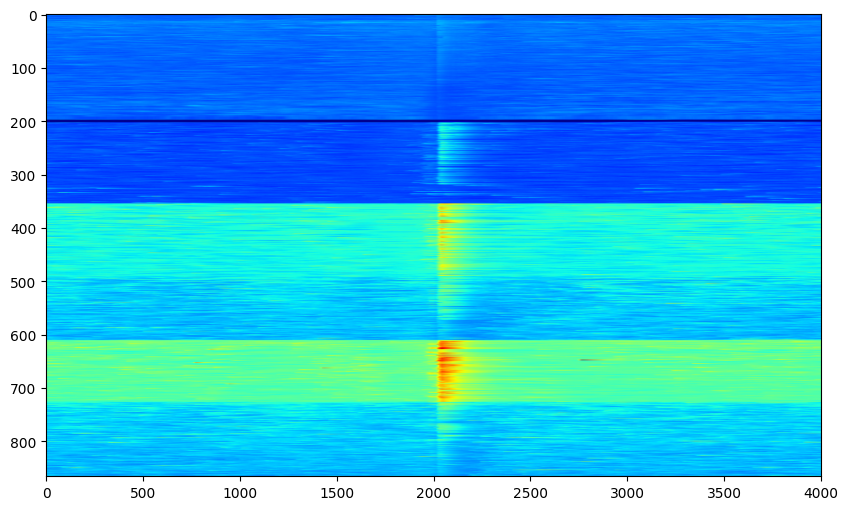

In [182]:
# Load data from .mat file
import scipy.io
# Select file from GUI
file_path = '/Volumes/MICROSCOPE/Shun/Project clamping/Results/dataset_20250210_200Hz.mat'
# file_path = '/Users/richardhakim/Desktop/dataset_20250210_200Hz.mat'
# Load the file
print(f"Loading file: {file_path}")
data = scipy.io.loadmat(file_path)

# Extract the data
reward_data = data['reward_data']
punish_data = data['punish_data']
combined_data = np.concatenate((reward_data, punish_data), axis=0)
combined_data = np.concatenate((combined_data[0:320], combined_data[480:]), axis=0) # optional: remove the 160 trials in the middle
print(f"Combined data shape: {combined_data.shape}")

# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(combined_data, aspect='auto', cmap='jet')

In [ ]:
class PID:
    def __init__(self, kp, ki, kd, output_range, pOnE=True, direction='reverse'):
        # Process variables
        self.myOutput = 0.0          # PID output value

        # PID direction
        self.direction = direction    # 'reverse' or 'direct'

        # PID tunings
        if self.direction == 'direct':
            self.kp = kp
            self.ki = ki
            self.kd = kd
        else:
            self.kp = -kp
            self.ki = -ki
            self.kd = -kd

        # Output limits
        self.outMin = output_range[0]
        self.outMax = output_range[1]

        # Mode settings
        self.pOnE = pOnE           # True: proportional on error; False: proportional on measurement

        # Internal PID state
        self.outputSum = 0.0
        self.lastInput = None  # To be set at the first sample

    def compute_from_signal(self, setpoint, signal):
        """
        Compute the PID output over a pre-recorded signal.
        `signal` is a list or numpy array of input values.
        Returns a list of PID outputs corresponding to each input sample.
        """
        outputs = []
        for _, input_val in enumerate(signal):
            if self.lastInput is None:
                # Initialize lastInput with the first sample if not set.
                self.lastInput = input_val

            error = setpoint - input_val
            dInput = input_val - self.lastInput

            # Integral term update
            self.outputSum += self.ki * error

            # Optionally subtract proportional on measurement
            if not self.pOnE:
                self.outputSum -= self.kp * dInput

            # Clamp the integral term
            self.outputSum = max(self.outMin, min(self.outputSum, self.outMax))

            # Proportional term if using proportional on error
            if self.pOnE:
                output = self.kp * error
            else:
                output = 0.0

            # Add the integral term and subtract derivative term
            output += self.outputSum - self.kd * dInput

            # Clamp overall output
            output = max(self.outMin, min(output, self.outMax))
            self.myOutput = output

            outputs.append(output)
            self.lastInput = input_val  # Update for next iteration

        return outputs

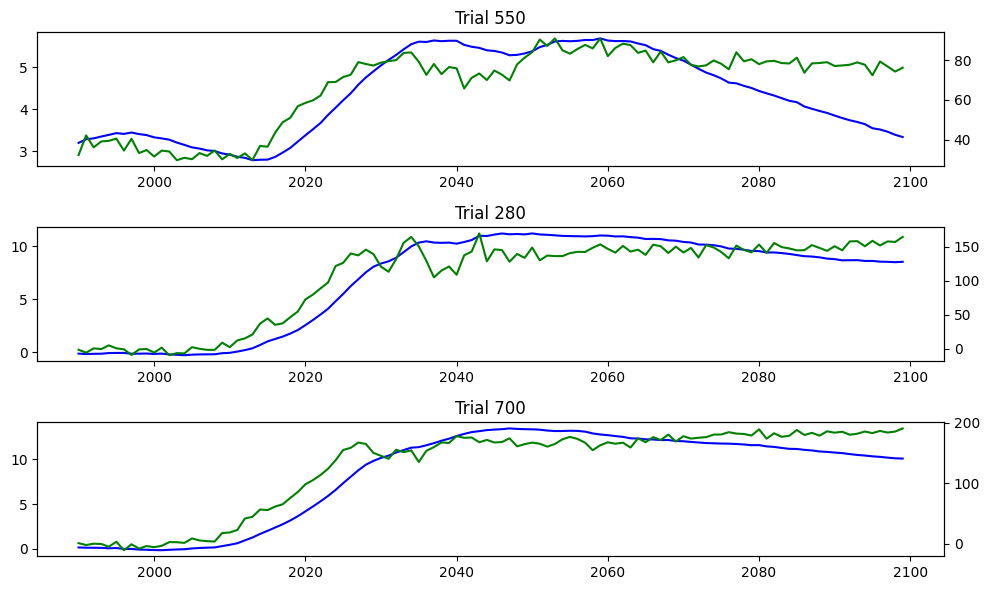

In [197]:
# Plot 3 samples around event (for PID analysis)
plotIdx = [550, 280, 700]
time_range = (-50, 500)
Fs = 200
normalize = 'zscore'

# Calculate baseline & baseline std
trial_baseline = np.mean(combined_data[plotIdx,0:2000], axis=1)
trial_std = np.std(combined_data[plotIdx,0:2000], axis=1)

plt.figure(figsize=(10, 6))
plot_window = np.arange(time_range[0]*Fs/1000 + 2000, time_range[1]*Fs/1000 + 2000, dtype=int)
for i in range(3):
    plt.subplot(3, 1, i+1)

    # Compute the trace and control signal
    pid = PID(kp=10, ki=0.1, kd=100, output_range=(-np.inf, np.inf), direction='reverse')
    raw_trace = combined_data[plotIdx[i],plot_window]
    baseline = trial_baseline[i]

    if normalize == 'zscore':
        trace_zscore = (raw_trace - baseline) / trial_std[i]
        trace = trace_zscore
        diff_trace = np.diff(trace, prepend=trace[0])
        pid_output = pid.compute_from_signal(0, trace)
    elif normalize == 'baseline':
        trace = raw_trace / baseline
        diff_trace = np.diff(trace, prepend=trace[0])
        pid_output = pid.compute_from_signal(1, trace)
    elif normalize == 'std':
        trace = raw_trace / trial_std[i]
        diff_trace = np.diff(trace, prepend=trace[0])
        pid_output = pid.compute_from_signal(baseline/trial_std[i], trace)
    else:
        trace = raw_trace
        diff_trace = np.diff(trace, prepend=trace[0])
        pid_output = pid.compute_from_signal(baseline, trace)


    # Plot the trace
    plt.plot(plot_window, trace, 'b')
    plt.twinx()
    plt.plot(plot_window, pid_output, 'g')
    plt.title(f"Trial {plotIdx[i]}")
plt.tight_layout()
plt.show()

In [12]:
# # Data featurization
# idx_rewardOnset = 2000
# nFeatures_rewardFeaturization_high = 5

# trial_bool_high = make_cosine_feature_traces(window=(-50, 50),     nFeatures=5, idx_event=2000, duration=combined_data.shape[1])
# trial_bool_med  = make_cosine_feature_traces(window=(-250, 250),   nFeatures=5, idx_event=2000, duration=combined_data.shape[1])
# trial_bool_low  = make_cosine_feature_traces(window=(-1000, 1000), nFeatures=5, idx_event=2000, duration=combined_data.shape[1])

# trial_bool_cat = np.concatenate((
#     trial_bool_high, 
#     trial_bool_med, 
#     trial_bool_low
# ), axis=1)

# plt.figure()
# plt.plot(trial_bool_cat[idx_rewardOnset + (-2000):idx_rewardOnset + (2000), :])

In [ ]:
Fs = 200
batch_duration = 500 # input window in samples
shift_prediction = int(Fs * 0.050)
batch_size = 512

In [263]:
X = combined_data.copy()
# X = X[np.random.choice(X.shape[0], X.shape[0], replace=False)]

print(f"X shape initial: {X.shape}")

bool_starting = np.ones_like(X, dtype=np.bool_)
bool_starting[:, :max(0, -shift_prediction)] = False
bool_starting[:, -(max(batch_duration, batch_duration + shift_prediction)):] = False

print(f"bool_starting shape: {bool_starting.shape}")

X shape initial: (866, 4001)
bool_starting shape: (866, 4001)


In [264]:
test_size = 0.3
val_size = 0.3

X_trainVal, X_test, bool_starting_trainVal, bool_starting_test = train_test_split(X, bool_starting, test_size=test_size, random_state=42)

X_train, X_val, bool_starting_train, bool_starting_val = train_test_split(X_trainVal, bool_starting_trainVal, test_size=val_size, random_state=42)

In [265]:
X_train_flat = X_train.reshape(-1)
bool_starting_train_flat = bool_starting_train.reshape(-1)
idx_starting_train_flat = np.where(bool_starting_train_flat)[0]

X_val_flat = X_val.reshape(-1)
bool_starting_val_flat = bool_starting_val.reshape(-1)
idx_starting_val_flat = np.where(bool_starting_val_flat)[0]

X_test_flat = X_test.reshape(-1)
bool_starting_test_flat = bool_starting_test.reshape(-1)
idx_starting_test_flat = np.where(bool_starting_test_flat)[0]

print(f"X shape: {X_train_flat.shape}")

X shape: (1696424,)


(950000.0, 980000.0)

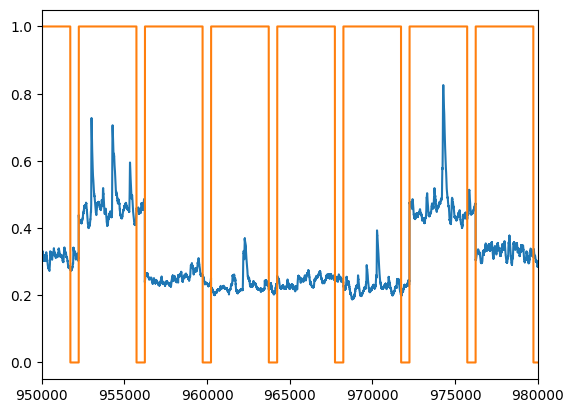

In [266]:
plt.figure()
plt.plot(X_train_flat)
plt.plot(bool_starting_train_flat)
plt.xlim(0.95e6, 0.98e6)
# plt.xlim([0, 4000])

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Sequence, Tuple, Optional
import matplotlib.pyplot as plt

class SequenceTimeSeriesDataset(Dataset):
    def __init__(
        self,
        data: torch.Tensor,
        valid_start_indices: Sequence[int],
        batch_duration: int,
        shifts: Optional[Tuple[int, ...]] = None,
    ):
        """
        Dataset for 1D time series data that returns contiguous sequences.
        
        Each sample returned is a contiguous block (trace) of the data,
        optionally returning at each time step a vector containing values 
        at different shifts.

        RH 2023

        Args:
            data (torch.Tensor):
                The 1D time series data.
            valid_start_indices (Sequence[int]):
                List/array of valid starting indices. These should be chosen
                so that for any start index s, the slice s : s+batch_duration 
                (and s+shift : s+batch_duration+shift for any shift) is valid.
            batch_duration (int):
                The length (number of timepoints) of each sequence.
            shifts (Optional[Tuple[int, ...]]):
                If provided, each timepoint will be returned as a vector
                containing the value at each shift. For example, if 
                shifts=(0, shift_prediction), then each timepoint in the 
                sequence will be a tensor of shape (2,). If not provided,
                each timepoint is returned as a scalar (and then unsqueezed to (1,)).
                Shifts is in units of samples, not time.
        """
        self.data = data
        self.valid_start_indices = list(valid_start_indices)
        self.batch_duration = batch_duration
        self.shifts = shifts

    def __len__(self) -> int:
        """
        Returns:
            int: The number of valid starting indices.
        """
        return len(self.valid_start_indices)

    def __getitem__(self, idx: int) -> torch.Tensor:
        """
        Returns a contiguous sequence (trace) from the time series.

        RH 2023

        Args:
            idx (int):
                Index into the list of valid starting indices.

        Returns:
            torch.Tensor:
                If shifts is provided, a tensor of shape 
                (batch_duration, len(shifts)); otherwise, a tensor of shape 
                (batch_duration, 1).
        """
        start_idx = self.valid_start_indices[idx]
        if self.shifts is None:
            # Return a contiguous sequence of single values.
            # unsqueeze(-1) to add a feature dimension.
            sequence = self.data[start_idx : start_idx + self.batch_duration].unsqueeze(-1)
        else:
            # Allocate a tensor to hold the sequence.
            num_shifts = len(self.shifts)
            sequence = torch.empty(
                (self.batch_duration, num_shifts),
                dtype=self.data.dtype,
                device=self.data.device,
            )
            # For each shift, slice the data appropriately.
            for j, shift in enumerate(self.shifts):
                # For a given shift, extract the sequence.
                sequence[:, j] = self.data[
                    start_idx + shift : start_idx + shift + self.batch_duration
                ]
        return sequence

In [268]:
def make_dataloader(x_flat, idx_starting_flat, batch_duration, batch_size, shift_prediction, device):
    dataset = SequenceTimeSeriesDataset(
        data=torch.as_tensor(x_flat, dtype=torch.float32, device=device),
        valid_start_indices=idx_starting_flat,
        batch_duration=batch_duration,
        shifts=(0, shift_prediction),
    )
    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        # pin_memory=True,
        num_workers=0,
    )
    return dataloader
    
dataloader_train, dataloader_val, dataloader_test = (make_dataloader(
    x_flat=x,
    idx_starting_flat=idx,
    batch_duration=batch_duration,
    batch_size=batch_size,
    shift_prediction=shift_prediction,
    device=device,
) for x, idx in zip(
    (X_train_flat, X_val_flat, X_test_flat),
    (idx_starting_train_flat, idx_starting_val_flat, idx_starting_test_flat),
))


Batch 0: shape torch.Size([512, 500, 2])
Batch 1: shape torch.Size([512, 500, 2])
Batch 2: shape torch.Size([512, 500, 2])


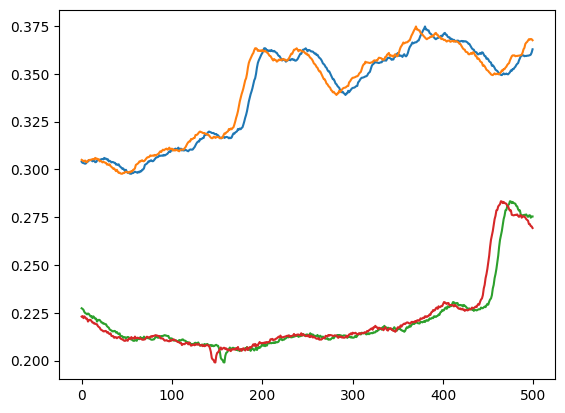

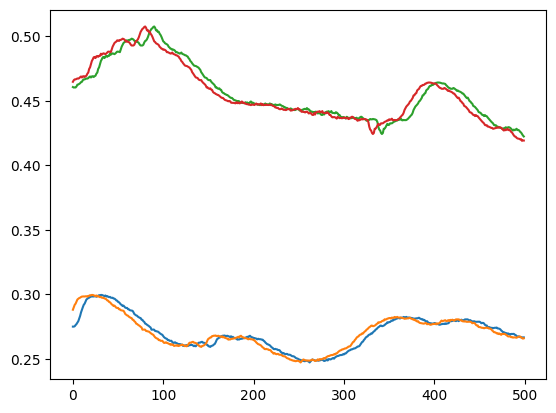

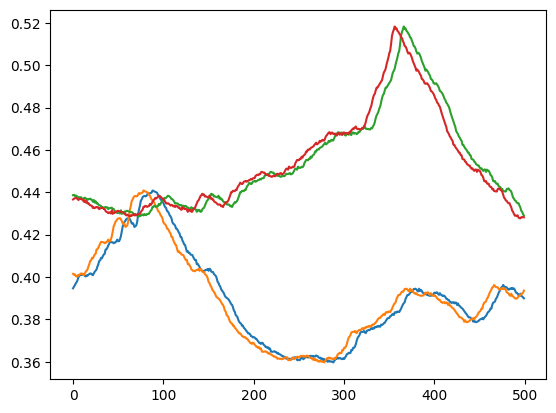

In [269]:
for ii, batch in enumerate(dataloader_train):
    print(f"Batch {ii}: shape {batch.shape}")
    # print(batch)
    
    plt.figure()
    plt.plot(batch[0].cpu())
    plt.plot(batch[1].cpu())
    
    if ii > 1:
        break

In [369]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2339],
         [ 0.0009],
         [ 0.0073],
         [-0.4380],
         [ 0.2446],
         [ 0.1320],
         [ 0.2818],
         [ 0.4029],
         [ 0.0651],
         [-0.1758],
         [-0.0806],
         [ 0.0565],
         [ 0.2303],
         [ 0.1449],
         [-0.4878],
         [-0.1060]], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([[-0.0652,  0.4089,  0.3482,  0.0113],
         [ 0.3603,  0.3783,  0.3500, -0.1110],
         [-0.0509, -0.1468,  0.0228, -0.1311],
         [ 0.3450, -0.1525,  0.1691,  0.1973],
         [ 0.0818,  0.4670,  0.4890, -0.1117],
         [ 0.0564, -0.2824, -0.1718,  0.1063],
         [ 0.2796, -0.4333, -0.4023,  0.4240],
         [-0.3121, -0.2896,  0.4994,  0.3692],
         [-0.4616,  0.4737, -0.4159,  0.3908],
         [-0.0713, -0.2449,  0.4583, -0.0401],
         [ 0.0860, -0.1295, -0.3924,  0.0747],
         [ 0.3431,  0.2385, -0.2551,  0.3794],
         [-0.2836, -0.2123,  0.3

In [370]:
# Model parameters
input_size = 1
hidden_size = 4  # Can be tuned
num_layers = 2
hidden_initialization = 'xavier_uniform'

# Initialize the model
model = RegressionRNN(
    features=input_size, 
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_size=1,
    batch_first=True,
    architecture='LSTM',
    kwargs_architecture={},
    nonlinearity='tanh',
    bias=True,
    dropout=0,
    bidirectional=False,
    device=device,
    dtype=torch.float32,
).to(device)

# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [371]:
# Set the number of training epochs.
num_epochs = 200

# Loop over epochs.
losses_train, losses_val, losses_test = {}, {}, {}
for epoch in range(num_epochs):
    ##############################
    # Training Phase
    ##############################
    model.train()  # Set the model to training mode.
    running_train_loss = 0.0
    num_train_samples = 0  # To compute an average loss per sample.
    
    for ii, batch in enumerate(dataloader_train):
        batch = batch.to(device)  # Last dim is (input, target).
        batch = batch - batch[:, 0, 0].unsqueeze(1).unsqueeze(2)
        # batch = batch / batch.std(dim=1, keepdim=True)
        inputs = batch[:, :, 0].unsqueeze(-1)   # shape: (batch_size, duration, 1)
        targets = batch[:, :, 1].unsqueeze(-1)
                
        optimizer.zero_grad()
        outputs, hidden = model(inputs) 
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Accumulate weighted training loss
        batch_size = inputs.size(0)
        running_train_loss += loss.item() * batch_size
        num_train_samples += batch_size
        
        losses_train[(epoch, ii)] = loss.item() / batch_size
        print(f"Batch iter: {ii} Loss: {loss.item():.7f}")
        
        if ii >= 100:
            break

    # Compute the average training loss over the epoch.
    avg_train_loss = running_train_loss / num_train_samples

    ##############################
    # Validation phase
    ##############################
    model.eval()  # Set the model to evaluation mode.
    running_val_loss = 0.0
    num_val_samples = 0
    
    with torch.no_grad():
        for ii, batch in enumerate(dataloader_val):
            batch = batch.to(device)  # Last dim is (input, target).
            batch = batch - batch[:, 0, 0].unsqueeze(1).unsqueeze(2)
            # batch = batch / batch.std(dim=1, keepdim=True)
            inputs = batch[:, :, 0].unsqueeze(-1)   # shape: (batch_size, duration, 1)
            targets = batch[:, :, 1].unsqueeze(-1)
            
            outputs, hidden = model(inputs)
            loss = criterion(outputs, targets)
            
            # Accumulate the validation loss.
            batch_size = inputs.size(0)
            running_val_loss += loss.item() * batch_size
            num_val_samples += batch_size
            
            losses_val[(epoch, ii)] = loss.item() / batch_size
            print(f"Validation iter: {ii} Loss: {loss.item():.7f}")
            
            if ii >= 10:
                break
    
    # Compute the average validation loss.
    avg_val_loss = running_val_loss / num_val_samples

    # Print the losses for the epoch.
    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss = {avg_train_loss:.7f}, Val Loss = {avg_val_loss:.7f}")

Batch iter: 0 Loss: 0.1453912
Batch iter: 1 Loss: 0.1174598
Batch iter: 2 Loss: 0.0913103
Batch iter: 3 Loss: 0.0734440
Batch iter: 4 Loss: 0.0568631
Batch iter: 5 Loss: 0.0433270
Batch iter: 6 Loss: 0.0317281
Batch iter: 7 Loss: 0.0222365
Batch iter: 8 Loss: 0.0150371
Batch iter: 9 Loss: 0.0087276
Batch iter: 10 Loss: 0.0050998
Batch iter: 11 Loss: 0.0024186
Batch iter: 12 Loss: 0.0016951
Batch iter: 13 Loss: 0.0020151
Batch iter: 14 Loss: 0.0027316
Batch iter: 15 Loss: 0.0034420
Batch iter: 16 Loss: 0.0054747
Batch iter: 17 Loss: 0.0060340
Batch iter: 18 Loss: 0.0065509
Batch iter: 19 Loss: 0.0067022
Batch iter: 20 Loss: 0.0069278
Batch iter: 21 Loss: 0.0068016
Batch iter: 22 Loss: 0.0058094
Batch iter: 23 Loss: 0.0052592
Batch iter: 24 Loss: 0.0048340
Batch iter: 25 Loss: 0.0039160
Batch iter: 26 Loss: 0.0031871
Batch iter: 27 Loss: 0.0028175
Batch iter: 28 Loss: 0.0022271
Batch iter: 29 Loss: 0.0020516
Batch iter: 30 Loss: 0.0017053
Batch iter: 31 Loss: 0.0016618
Batch iter: 32 Los

In [372]:
# Optionally, evaluate on the test set after training.
model.eval()
running_test_loss = 0.0
num_test_samples = 0
with torch.no_grad():
    for ii, batch in enumerate(dataloader_test):
        batch = batch.to(device)  # Last dim is (input, target).
        batch = batch - batch[:, 0, 0].unsqueeze(1).unsqueeze(2)
        # batch = batch / batch.std(dim=1, keepdim=True)
        inputs = batch[:, :, 0].unsqueeze(-1)   # shape: (batch_size, duration, 1)
        targets = batch[:, :, 1].unsqueeze(-1)

        outputs, _ = model(inputs)
        loss = criterion(outputs, targets)
        batch_size = inputs.size(0)
        running_test_loss += loss.item() * batch_size
        num_test_samples += batch_size
        
        losses_test[(epoch, ii)] = loss.item() / batch_size
        print(f"Test iter: {ii} Loss: {loss.item():.7f}")
        
        if ii >= 1:
            break
avg_test_loss = running_test_loss / num_test_samples
print(f"Test Loss: {avg_test_loss:.7f}")

Test iter: 0 Loss: 0.0000196
Test iter: 1 Loss: 0.0000202
Test Loss: 0.0000199


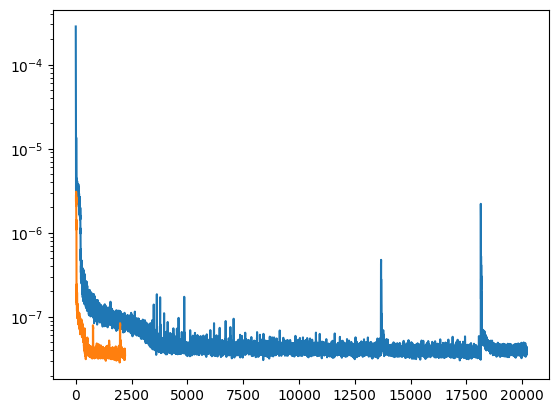

In [373]:
plt.figure()
plt.plot(list(losses_train.values()), label='Train')
plt.plot(list(np.ones(10) * np.nan) + list(losses_val.values()), label='Validation')
plt.yscale('log')

/var/folders/rj/y1_9lfn16mg3r0j3qg45dxw40000gn/T/ipykernel_25313/2474983543.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


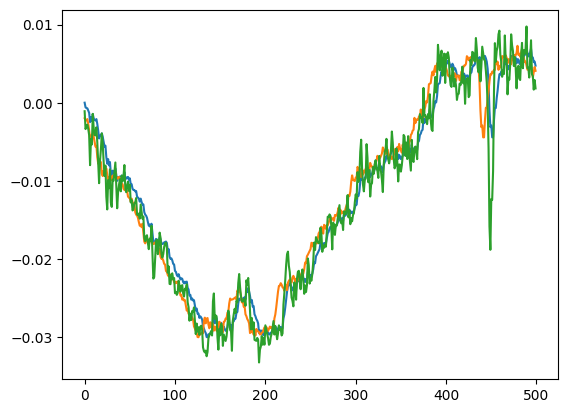

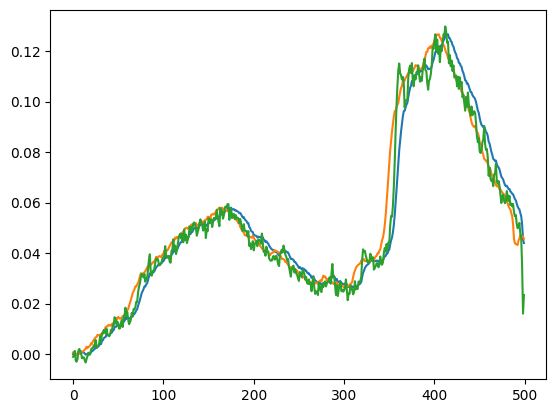

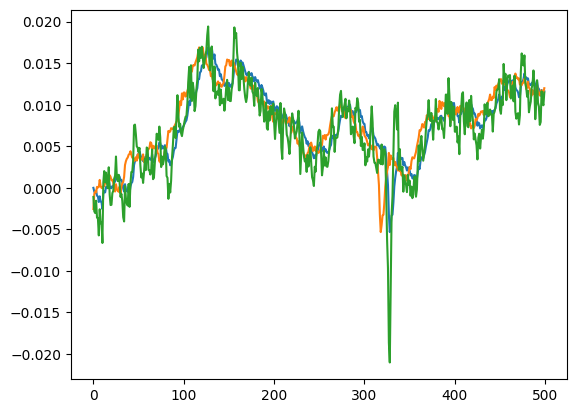

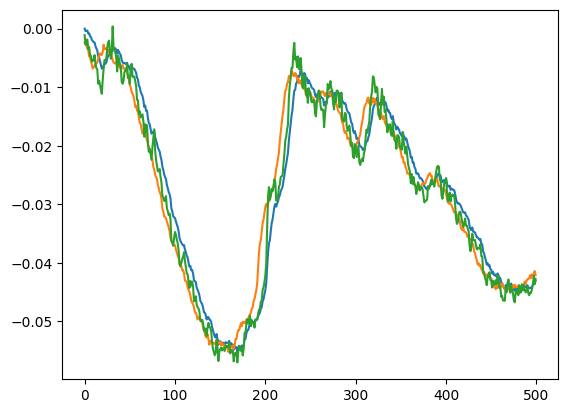

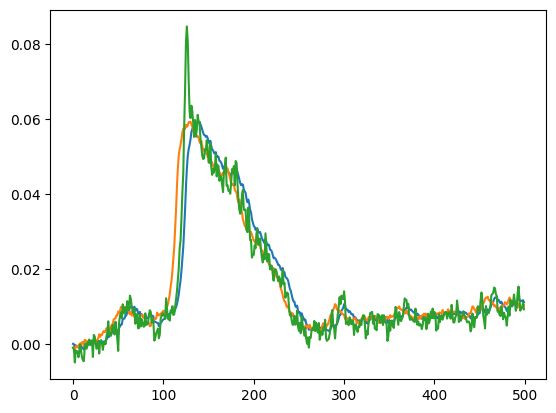

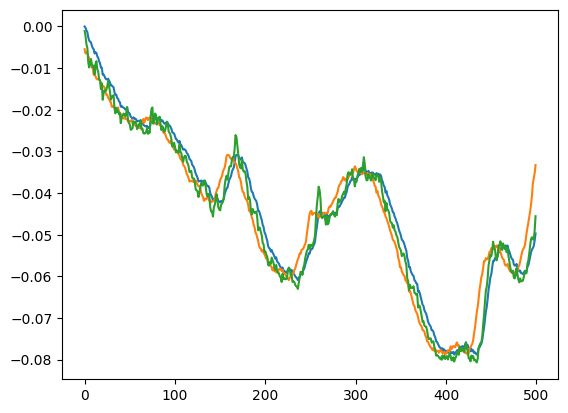

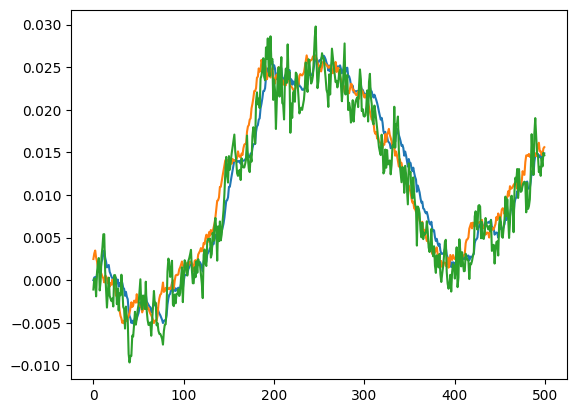

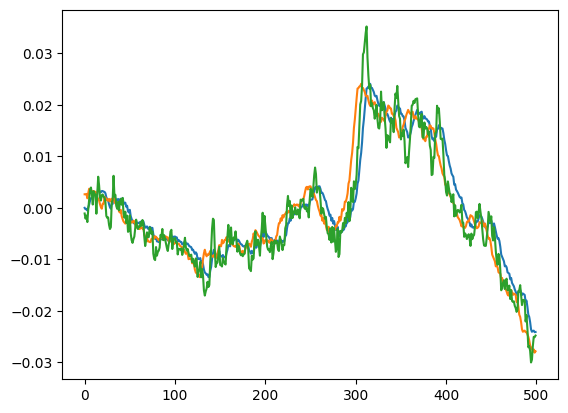

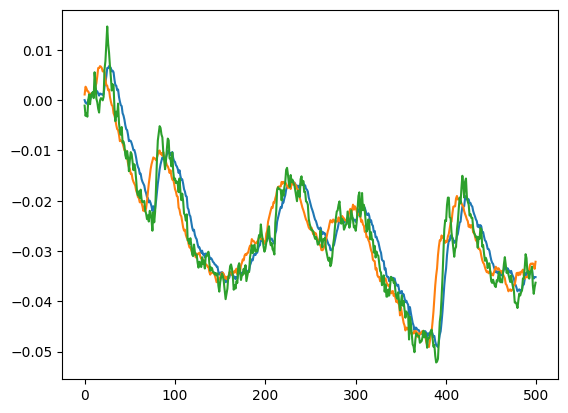

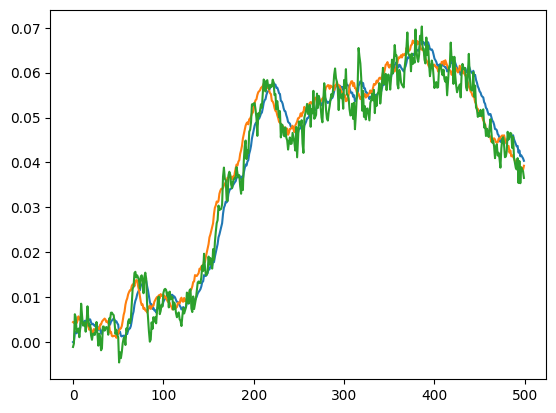

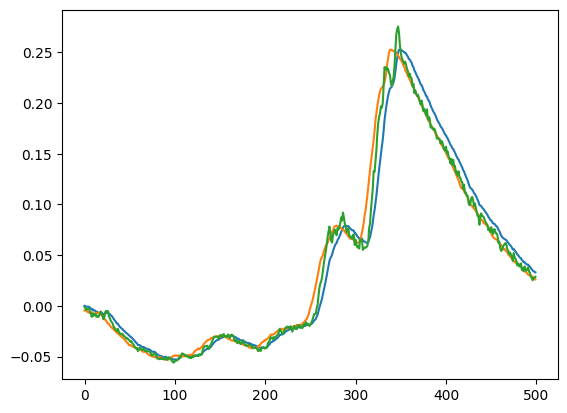

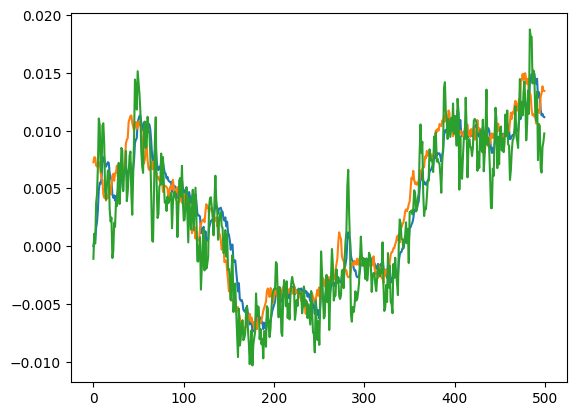

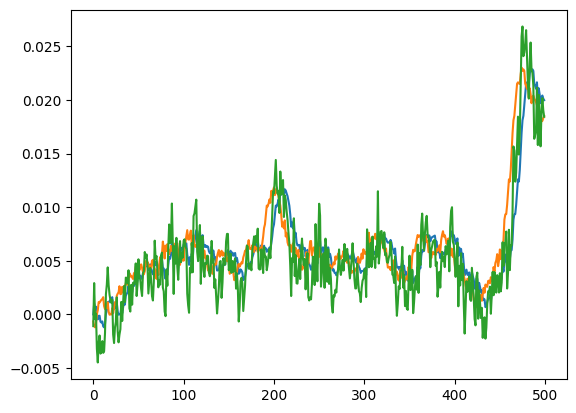

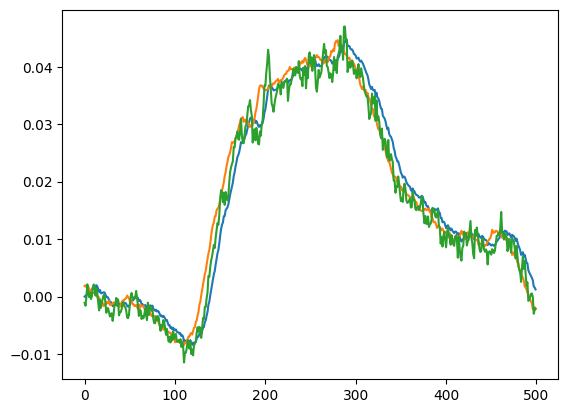

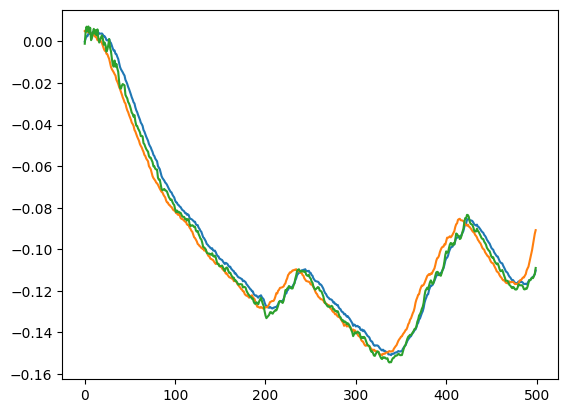

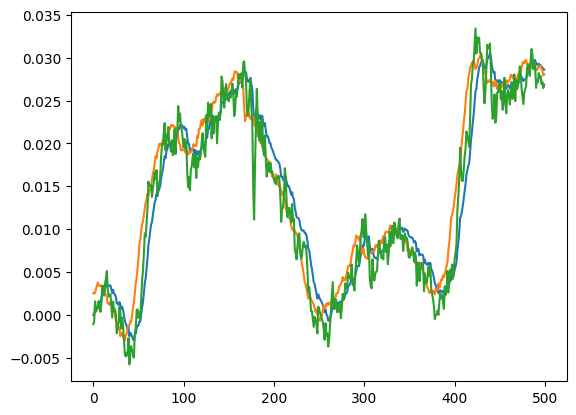

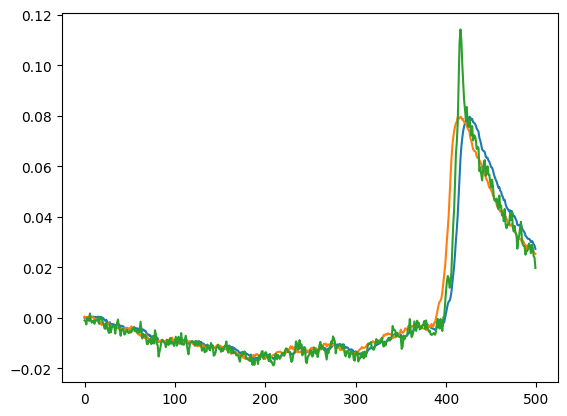

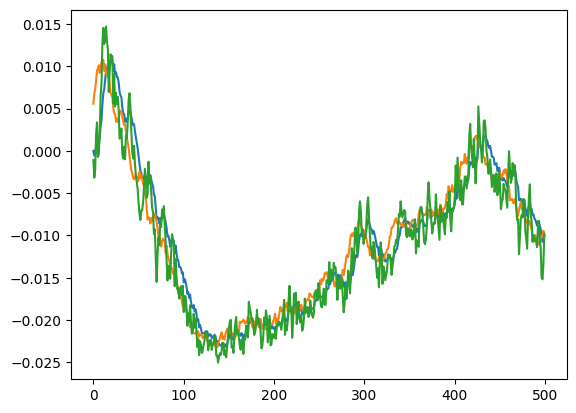

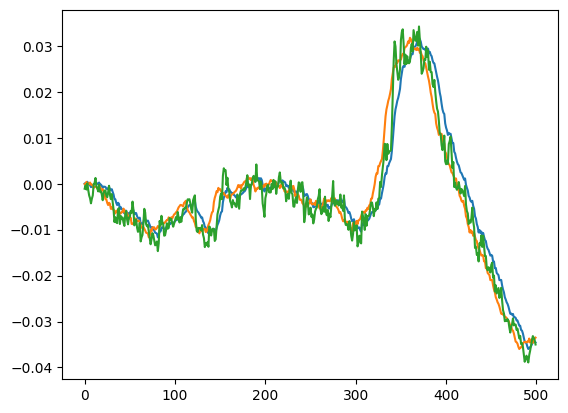

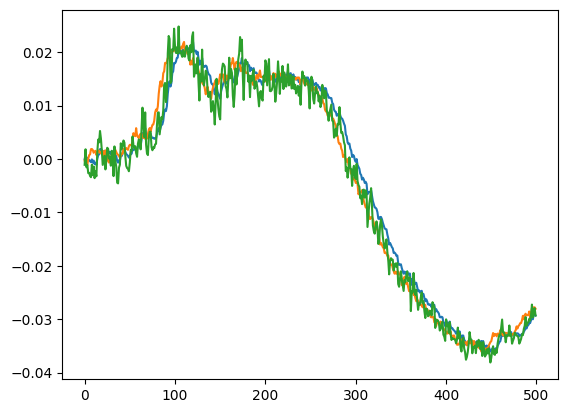

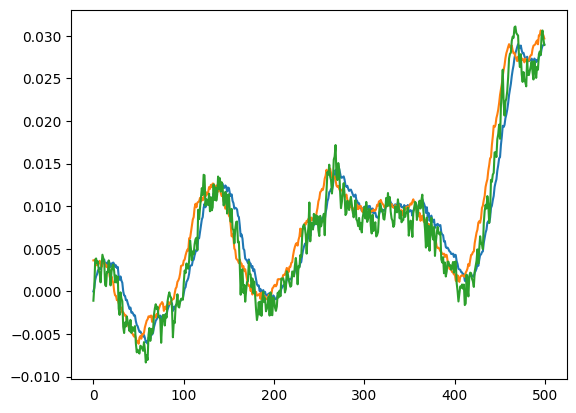

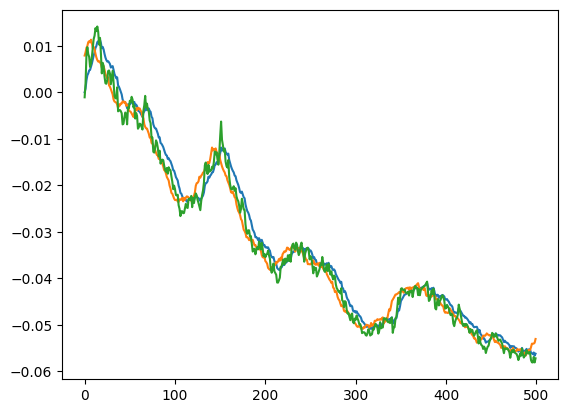

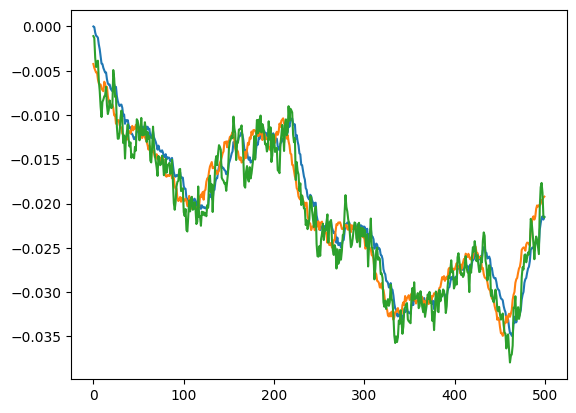

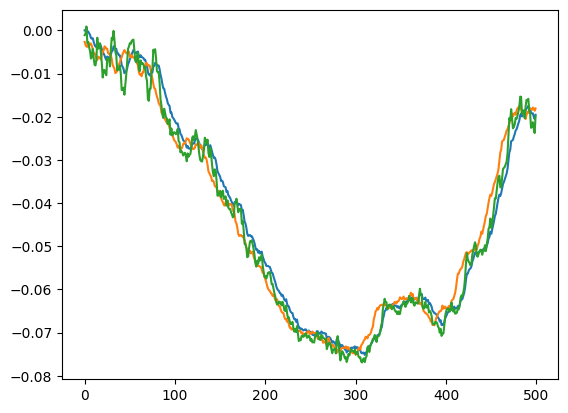

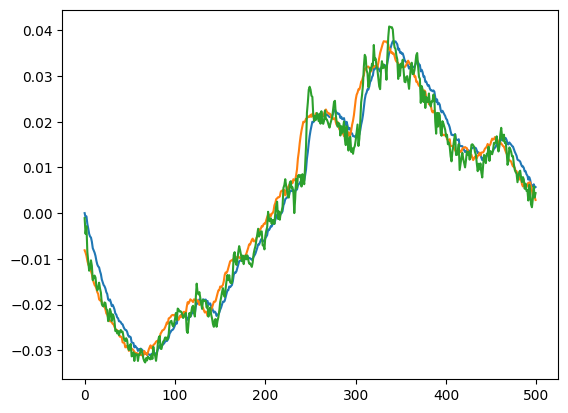

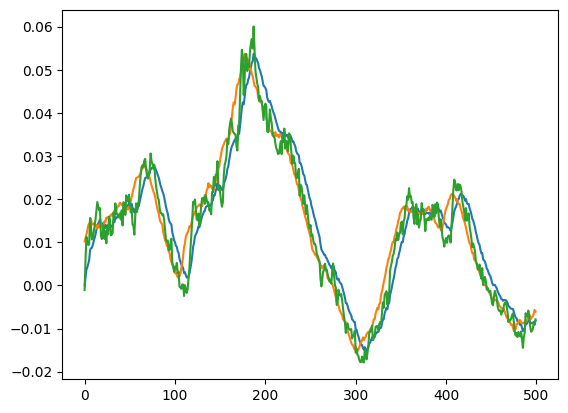

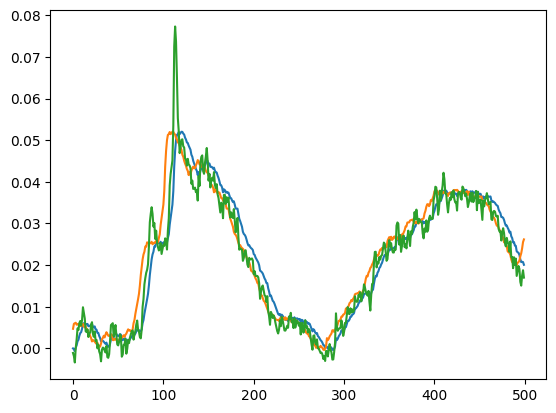

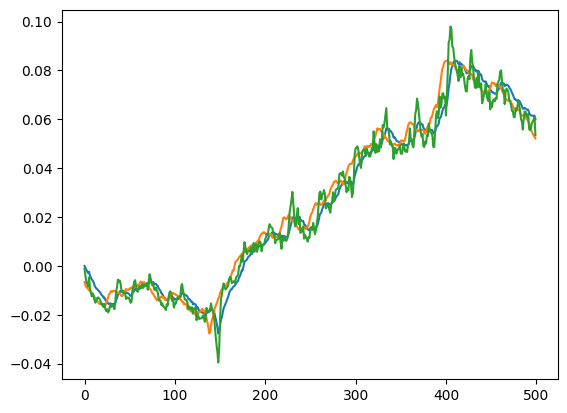

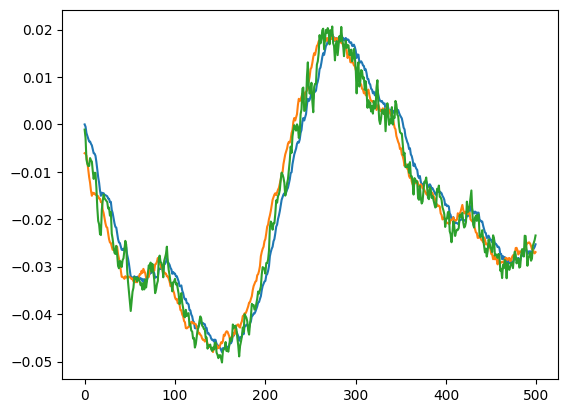

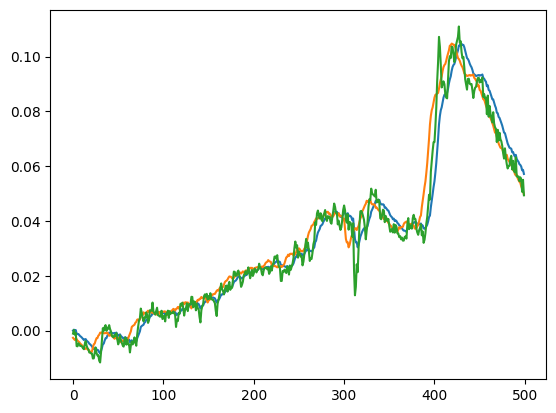

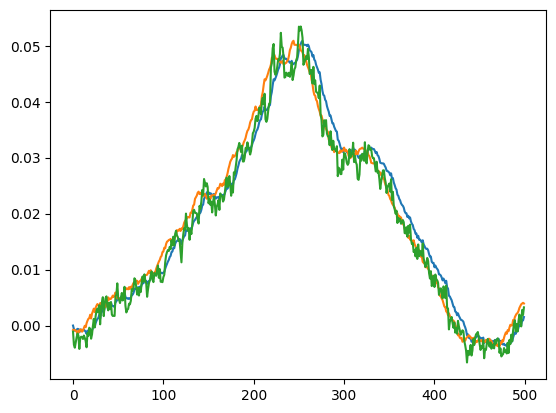

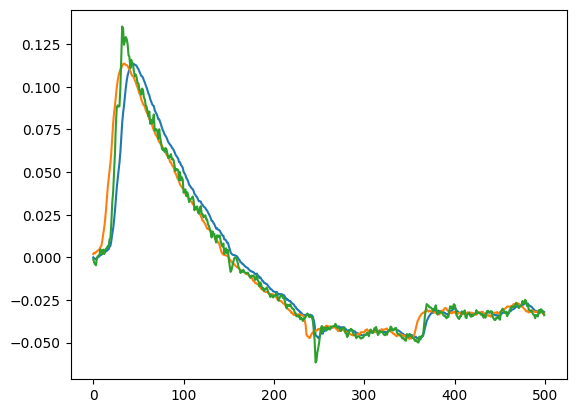

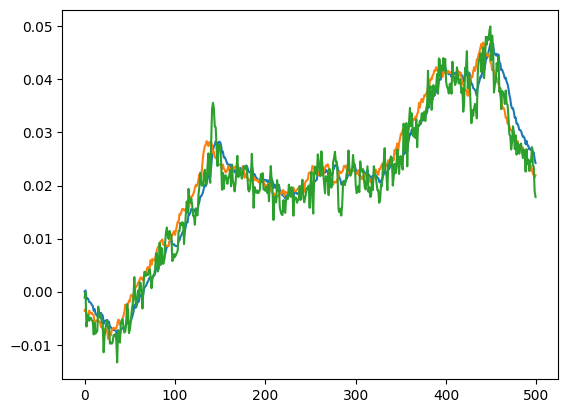

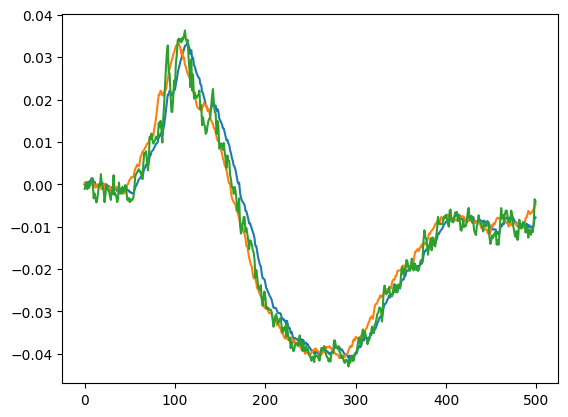

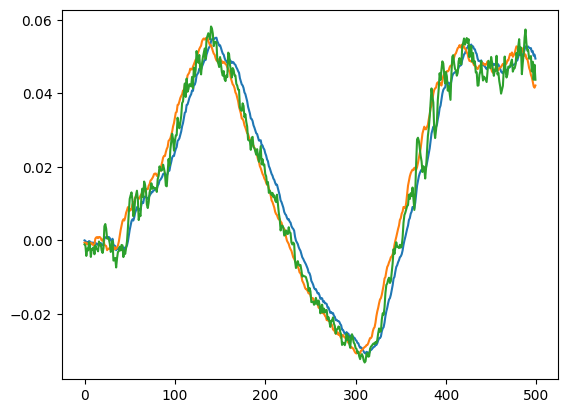

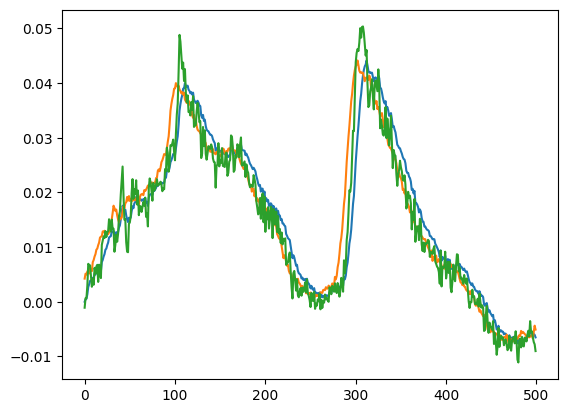

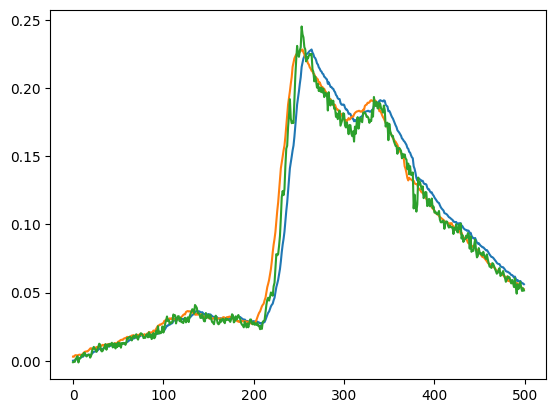

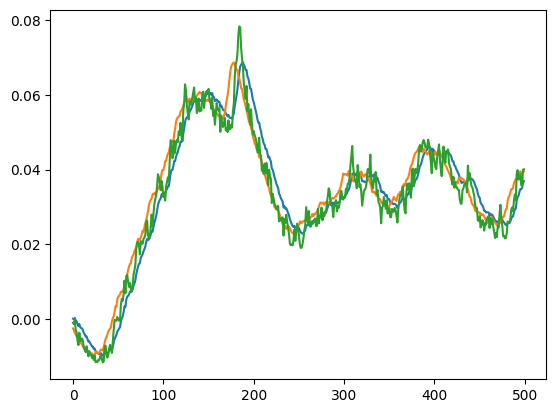

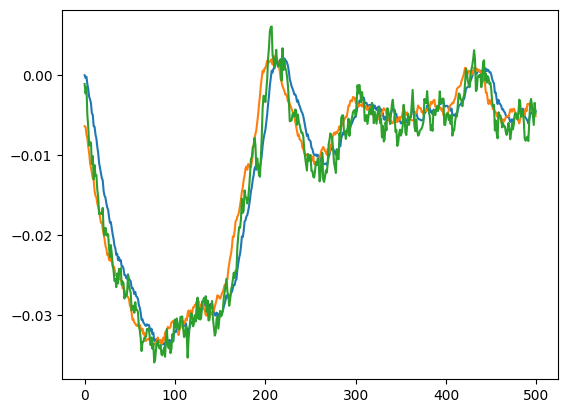

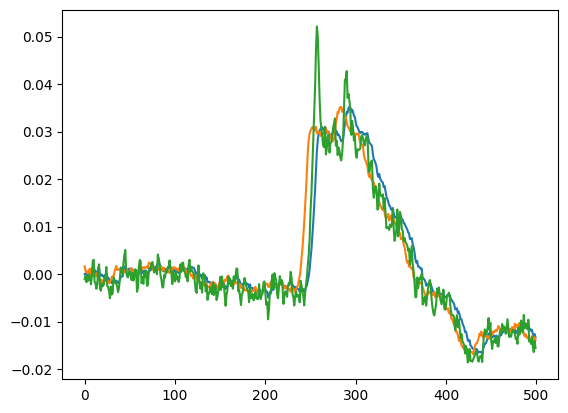

In [374]:
for idx in range(40):
    plt.figure()
    plt.plot(inputs[idx].detach().cpu().numpy(), label='Input')
    plt.plot(targets[idx].detach().cpu().numpy(), label='Target')
    plt.plot(outputs[idx].detach().cpu().numpy(), label='Output')
    # plt.ylim([-0.2, 0.2])